Shark and Human Tracking using Faster R-CNN with ResNet 50 FPN Backbone\
Author: Nic Tekieli\
Code adapted from articles [How to train an Object Detector with your own COCO dataset in PyTorch](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5) and [Evaluating Object Detection with FiftyOne](https://voxel51.com/docs/fiftyone/tutorials/evaluate_detections.html)

Simple script using OpenCV to extract images in JPEG format from a video. Changing the line `if count % 20 == 0:` from 20 to another value will change how many frames between extracting each image. Currently, the script will extract an image every 20 frames. `newvideos` can also be changed to whatever directory your videos are stored in.\
Once you extract the images, either continue and use them as an ImageDirectory or annotate using a tool (ex. CVAT) and extract as COCO files

In [ ]:
import cv2
import os

def extractFromMP4(filename):
    print("hello")
    vidcap = cv2.VideoCapture("newvideos/" + filename + ".mp4")
    success, image = vidcap.read()
    print(success)
    count = 0
    picCount = 1
    os.makedirs(filename, exist_ok=True)

    while success:
        success, image = vidcap.read()
        if count % 20 == 0:
            print("extracting img")
            cv2.imwrite(filename + "/" + filename + "%d.jpeg" %
            (picCount), image) #saving the frame as a jpeg image
            picCount += 1
        count += 1

In [ ]:
extractFromMP4("example_video")

In [ ]:
# Reinstalling a version of OpenCV that is compatible with FiftyOne
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52
!pip install fiftyone

     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 1.3 MB 13.2 MB/s 
     |████████████████████████████████| 13.2 MB 68.9 MB/s 
     |████████████████████████████████| 106 kB 49.7 MB/s 
     |████████████████████████████████| 29.2 MB 1.2 MB/s 
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
     |████████████████████████████████| 133 kB 57.5 MB/s 
     |████████████████████████████████| 564 kB 67.7 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 508 kB 53.1 MB/s 
     |████████████████████████████████| 226 kB 69.4 MB/s 
     |████████████████████████████████| 47 kB 3.8 MB/s 
     |████████████████████████████████| 132 kB 67.7 MB/s 
     |████████████████████████████████| 84 kB 1.9 MB/s 
     |████████████████████████████████| 68 kB 4.9 MB/s 
     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |███████████████████

In [ ]:
import fiftyone as fo

NumExpr defaulting to 2 threads.
Migrating database to v0.15.1


Modifying the PyTorch Dataset class to use with COCO data. \
__getitem__ needed to be modified in order to get a key for sample data

In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # converting from coco to pytorch
        # bbox = [xmin, ymin, width, height] -> [xmin, ymin, xmax, ymax]
        boxes = []
        area = 0
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            area += (xmax-xmin)*(ymax-ymin)
        area = torch.as_tensor(area, dtype=torch.float32)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        if num_objs == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels ["Background", "Human", "Shark"]
        labels = torch.ones((num_objs,), dtype=torch.int64)

        for index, obj in enumerate(coco_annotation):
          labels[index] = obj['category_id']

        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
# helper func that add .ToTensor() to the transforms
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

This can be modified to your own dataset. Replace the contents of `train_data_dir` with the path to your COCO folder that contains the JPEG images of your annotated data and replace the contents of `train_coco` with the path to your COCO folder that contains the JSON file with your annotations.

In [ ]:
# path to your own data and coco file
train_data_dir = '/content/drive/MyDrive/training_data/data'
train_coco = '/content/drive/MyDrive/training_data/annotations/evaluation_annotations.json'
dataset_type = fo.types.COCODetectionDataset

# create own Dataset using custom class
training_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
# num_workers set to 2 for use in google colab, can be changed if you have access
# to other computational machines
data_loader = torch.utils.data.DataLoader(training_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


Prints out the tensors for our image annotations. The line `print(annotations)` can be ommitted but its nice to see what our annotations look like in the PyTorch format

In [ ]:
# select device (whether GPU or CPU)
# tries to use GPU first, then cpu if GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

[{'boxes': tensor([[1977.9200,  701.2800, 2085.8101,  756.5800],
        [2226.0701,  438.2600, 2315.9800,  512.7600]]), 'labels': tensor([2, 1]), 'image_id': tensor([115]), 'area': tensor([5966.3169, 6698.2949]), 'iscrowd': tensor([0, 0])}]
[{'boxes': tensor([[1585.5400, 1039.4600, 1828.7600, 1227.6600],
        [1006.4500,  639.8900, 1403.1300,  822.3000]]), 'labels': tensor([2, 1]), 'image_id': tensor([186]), 'area': tensor([45774.0039, 72358.3984]), 'iscrowd': tensor([0, 0])}]
[{'boxes': tensor([[2030.2700,  953.0900, 2095.7000, 1035.3000],
        [2840.6699,  646.0400, 2877.5801,  726.5800],
        [3105.7700,  998.3900, 3187.9900, 1047.0500]]), 'labels': tensor([2, 1, 1]), 'image_id': tensor([9]), 'area': tensor([5379.0005, 2972.7314, 4000.8252]), 'iscrowd': tensor([0, 0, 0])}]
[{'boxes': tensor([[1715.8300, 1108.9500, 1999.5900, 1245.0300],
        [1272.8300,  697.8000, 1628.9700,  914.9500]]), 'labels': tensor([2, 1]), 'image_id': tensor([199]), 'area': tensor([38614.0625, 7

Training our model `model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)` on our training dataset. This model currently has the parameter `pretrained=False` but this can be changed if you have a large dataset to train on. Currently set to 10 epochs

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# 3 classes; Only target classes or background
num_classes = 3
num_epochs = 10
model = get_model_instance_segmentation(num_classes)

# set model to use the chosen device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)



for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Saves the current state of our model weights to a file that can be used if we would like to evaluate a different dataset on the model that we've already trained

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights')

Create a new dataset containing our validation data. Currently creates two datasets to test our model on data its trained on as well as new data with labels.\
the first dataset block contained the line `dataset_type=fo.types.ImageDirectory` which creates a dataset that only contained images without a JSON file for annotations. This can be used if you want to test the model on images that you can check manually for accuracy

In [ ]:
# Get class list
classes = ['Background', 'Human', 'Shark']

# eval_dataset = fo.Dataset.from_dir(
#     dataset_dir='/content/drive/MyDrive/eval_data/data',
#     dataset_type=fo.types.ImageDirectory,
#     name="evaluation images 3"
# )

subset_dataset_full = fo.Dataset.from_dir(
    dataset_type=dataset_type,
    data_path=train_data_dir,
    labels_path=train_coco
)

subset_dataset = subset_dataset_full.take(100, seed=51)

evaluation_test = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path="/content/drive/MyDrive/evaluation_test_dataset/data",
    labels_path="/content/drive/MyDrive/evaluation_test_dataset/annotations/instances_default.json"
)



print(evaluation_test.default_classes)
print(evaluation_test)

 100% |█████████████████| 210/210 [631.2ms elapsed, 0s remaining, 332.7 samples/s]      
 100% |███████████████████| 49/49 [233.1ms elapsed, 0s remaining, 210.2 samples/s]     


Launches the FiftyOne app within the notebook. Use the `[desktop]` flag to launch as an application instead

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


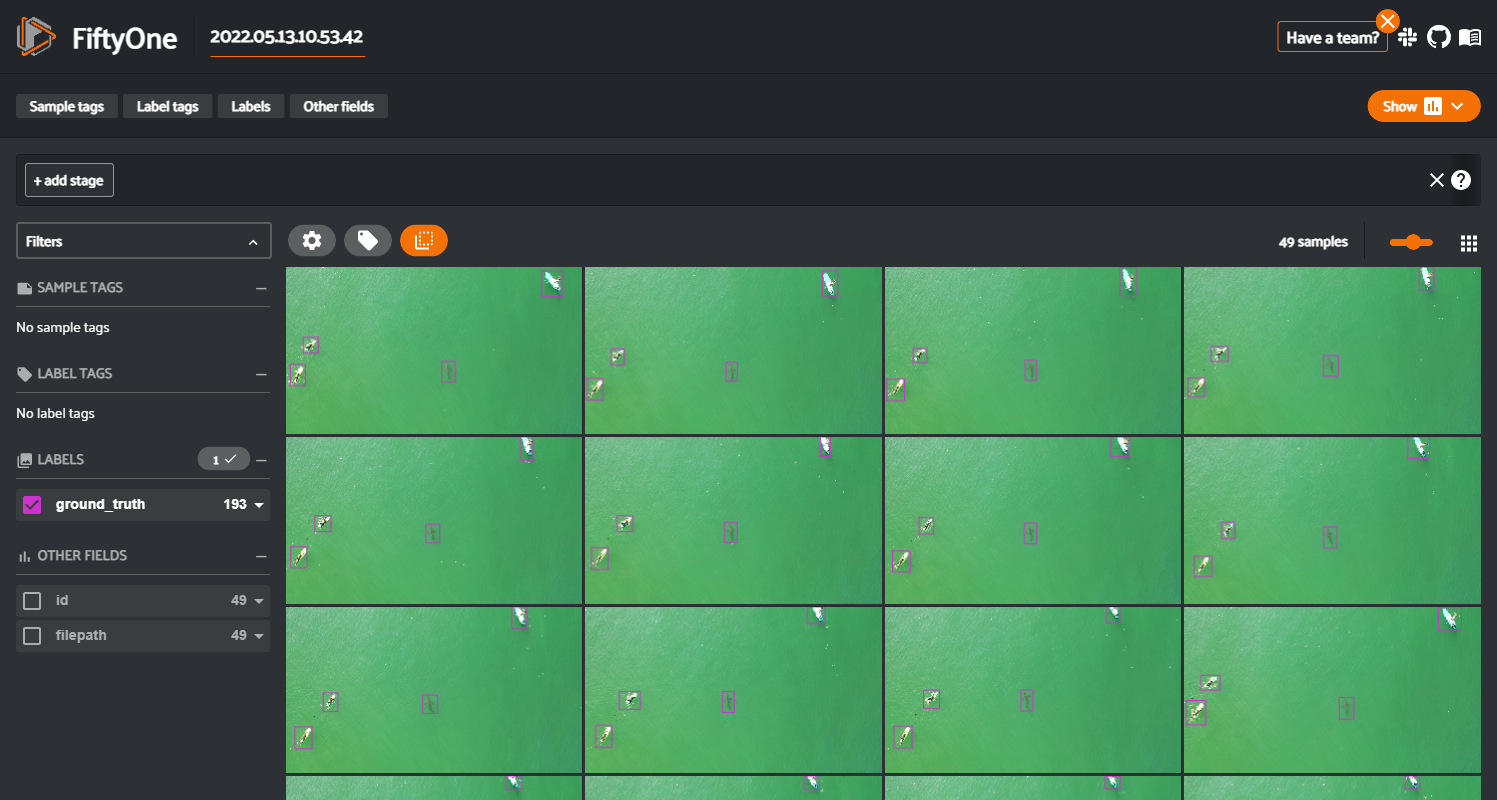

<IPython.core.display.Javascript object>

In [ ]:
session = fo.launch_app(evaluation_test)

Performing inference on the validation dataset using the model we just trained. Omit `model.load_state_dict(torch.load("/content/drive/MyDrive/model_weights", map_location="cpu"))` if you've just trained the model.\
The line `model.eval()` is necessary in order to perform inference using a model that has already been trained

In [ ]:
from PIL import Image
from torchvision.transforms import functional as func

model.load_state_dict(torch.load("/content/drive/MyDrive/model_weights", map_location="cpu"))
model.eval()
# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(evaluation_test):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape

        # Perform inference
        preds = model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["faster_rcnn"] = fo.Detections(detections=detections)
        sample.save()

 100% |███████████████████| 49/49 [8.8m elapsed, 0s remaining, 0.1 samples/s]     
Finished adding predictions


Opens a new FiftyOne session that now includes the validation data with predictions and confidence intervals

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


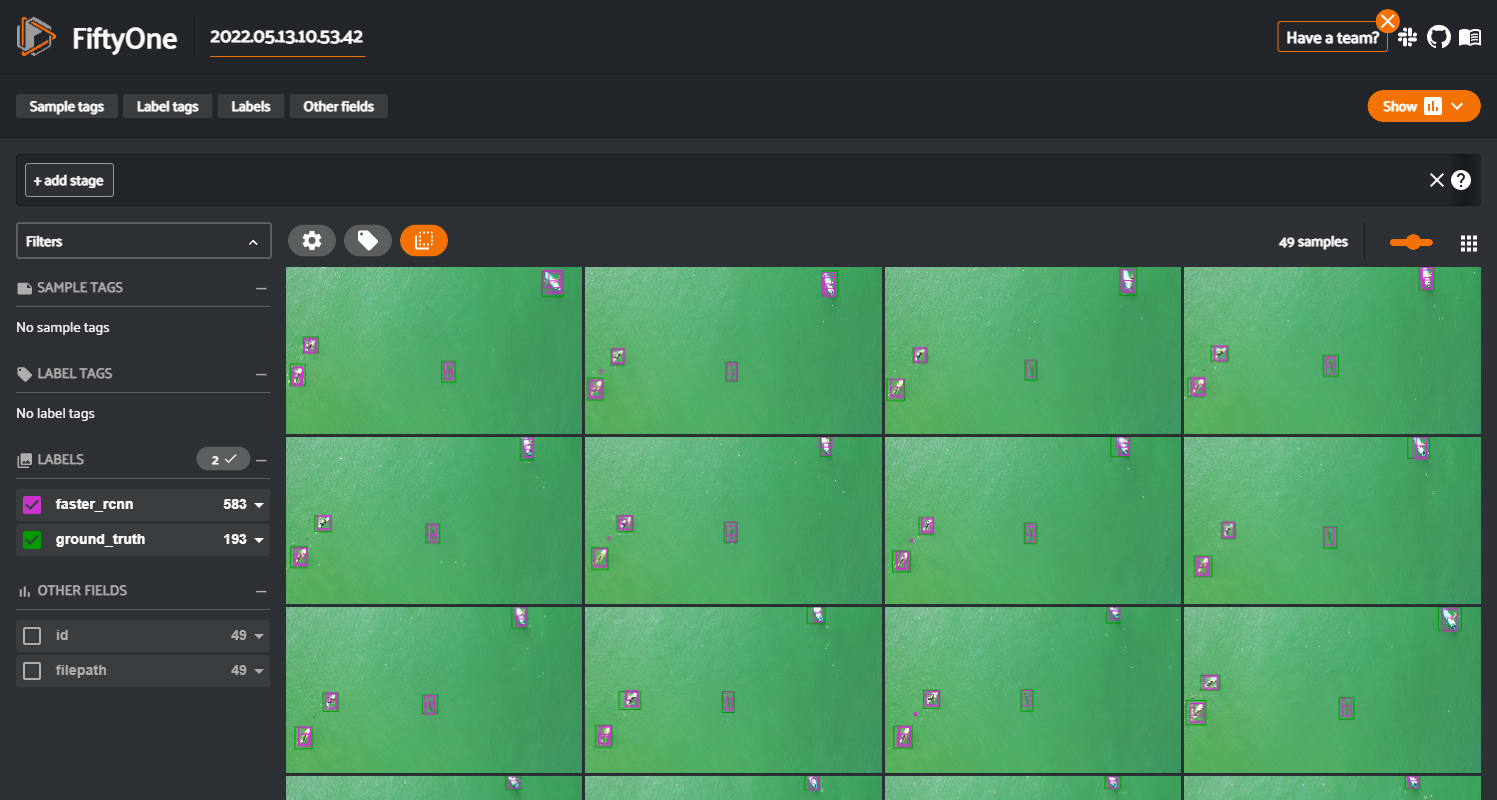

<IPython.core.display.Javascript object>

In [ ]:
session.view = None

Filters all detections with confidence >= 0.75 to gather the data that has the highest confidence

In [ ]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = evaluation_test.filter_labels("faster_rcnn", F("confidence") > 0.75)

In [ ]:
print(high_conf_view)

Dataset:     2022.05.13.10.00.33
Media type:  image
Num samples: 49
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='faster_rcnn', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=True, trajectories=False)


Runs evaluation to assess the quality of only the high confidence predictions in our dataset

In [ ]:
results = high_conf_view.evaluate_detections(
    "faster_rcnn",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████████| 49/49 [767.5ms elapsed, 0s remaining, 63.8 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 49/49 [616.1ms elapsed, 0s remaining, 79.5 samples/s]      


In [ ]:
# Get the two classes in the dataset
counts = evaluation_test.count_values("ground_truth.detections.label")
classes_data = sorted(counts, key=counts.get, reverse=True)[:2]

# Print a classification report for the two classes
results.print_report(classes=classes_data)

              precision    recall  f1-score   support

       Human       0.78      0.83      0.80       144
       Shark       0.92      0.98      0.95        49

   micro avg       0.82      0.87      0.84       193
   macro avg       0.85      0.90      0.88       193
weighted avg       0.82      0.87      0.84       193



In [ ]:
print(results.mAP())

0.17187341023589814


In [ ]:
plot = results.plot_pr_curves(classes=["Human", "Shark"])
plot.show()